In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anthonytherrien/dog-vs-cat")

print("Path to dataset files:", path)

/home/pgurzhii/miniforge3/envs/hic/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/pgurzhii/.cache/kagglehub/datasets/anthonytherrien/dog-vs-cat/versions/3


In [19]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import seaborn as sns

In [20]:
class ClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        :param root_dir: Путь к директории с данными. Внутри должно быть N папок, каждая соответствует своему классу.
        :param transform: Трансформации, которые будут применяться к изображениям.
        """
        self.root_dir = root_dir
        self.transform = transform

        # Список всех папок (классов) в корневой директории
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        # ["cat", "dog"]

        # Количество классов
        self.num_classes = len(self.classes)

        # Создание маппинга класс -> индекс
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        # {"cat":0, "dog":1}

        # Список всех изображений и их классов
        self.samples = []
        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name) # путь к директории конкретного класса
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                if os.path.isfile(img_path):
                    self.samples.append((img_path, self.class_to_idx[class_name])) 
                    # (путь к изображению, номер класса)

        # One-hot encoding для классов
        self.one_hot_classes = np.eye(self.num_classes)
        # numpy.eye(num of rows in output) 
        # Return a 2-D array with ones on the diagonal and zeros elsewhere.
        # [[1, 0],
        # [0, 1]]

    def __len__(self):
        """Возвращает длину датасета"""
        return len(self.samples) # кол-во изображений всего

    def __getitem__(self, idx):
        """
        Возвращает элемент датасета по индексу.
        :param idx: Индекс элемента
        :return: Кортеж (изображение, one-hot класс)
        """
        img_path, class_idx = self.samples[idx] # путь к изображению, номер класса

        # Загрузка изображения
        image = Image.open(img_path).convert('RGB') # PIL

        # Применение трансформаций (если есть)
        if self.transform:
            image = self.transform(image)

        # One-hot encoding для класса
        label = self.one_hot_classes[class_idx]

        return image, torch.tensor(label, dtype=torch.float32) 
        # тензор, представляющий метку класса в формате one-hot encoding.
        # tensor([0., 1.])

### Добавление аугментации

In [21]:
dataset = ClassificationDataset(
    root_dir=os.path.join(path, "animals"),  
    transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменение размера изображения
    transforms.RandomHorizontalFlip(),  # Случайное горизонтальное отражение
    transforms.RandomRotation(30),  # Случайный поворот изображения на угол до 30 градусов
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Случайное изменение яркости, контраста, насыщенности и оттенка
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Случайная аффинная трансформация (сдвиг изображения)
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),  # Случайная перспектива (изменение угла и искажения)
    transforms.RandomCrop(200),  # Случайная обрезка изображения
    transforms.ToTensor(),  # Преобразование изображения в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
  ])
)
# Аугментация помогает модели стать более устойчивой к шумам, искажениям и вариациям, которые могут встречаться в реальных данных

print(f"Количество классов: {dataset.num_classes}")
print(f"Классы: {dataset.classes}")
print(f"Количество образцов: {len(dataset)}")

# Получение первого элемента
image, label = dataset[0]
print(f"Размер изображения: {image.size()}")
print(f"One-hot метка: {label}")

Количество классов: 2
Классы: ['cat', 'dog']
Количество образцов: 1000
Размер изображения: torch.Size([3, 200, 200])
One-hot метка: tensor([1., 0.])


### Визуализация рандомной афинной трансформации

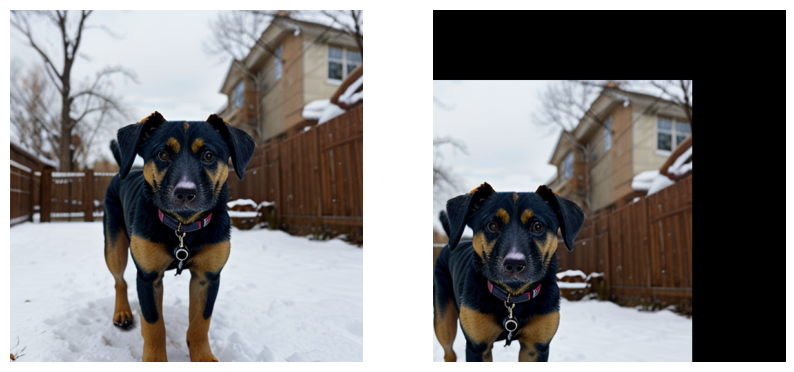

In [5]:
examp1_dataset = ClassificationDataset(root_dir=os.path.join(path, "animals"))
examp2_dataset = ClassificationDataset(root_dir=os.path.join(path, "animals"),
                 transform = transforms.Compose([transforms.RandomAffine(degrees=0, translate=(0.3, 0.3))]))

image, _ = examp1_dataset[600]
image2, _ = examp2_dataset[600]

# Визуализируем изображение
plt.figure(figsize=(10,12))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')  

plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.axis('off')  
plt.show()

In [22]:
def data_split(dataset, size_of_train=0.8, batch_size=32):

    train_size = int(size_of_train * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size],
                                               generator=torch.Generator().manual_seed(18)) #torch.utils.data

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # Вместо обработки одного элемента за раз, DataLoader группирует элементы в батчи, это ускоряет обучение
    # Загрузка данных и передача их в модель по одному элементу создает дополнительные накладные расходы
    # При batch_size=32 градиенты становятся более стабильными, так как они усредняются по нескольким примерам.
    # shuffle=True чтобы модель не запомниала порядок данных
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Количество классов: {dataset.num_classes}")
    print(f"Классы: {dataset.classes}")
    print(f"Количество образцов: {len(dataset)}")
    print(f"Train size: {train_size}, Test size: {test_size}")
    
    return train_loader, test_loader

In [46]:
def model_construction(dataset,lr=0.0001, weight_decay=0):

    # Создание предобученной модели resnet18
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.resnet18(pretrained=True) # Веса модели инициализируются на основе обучения на наборе данных ImageNet
    model.fc = nn.Linear(model.fc.in_features, dataset.num_classes)  # Замена последнего слоя под количество классов (1000 -> 2)
    # model.fc.in_features — это количество входных признаков для последнего слоя (512 для ResNet-18)
    # входных: 512, выходных: 2
    model = model.to(device)

    # Функция потерь:
    criterion = nn.CrossEntropyLoss() # Разница между площадью распределения модели и площадью разметки

    # Оптимизатор
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay) 
    # model.parameters() — все обучаемые параметры модели
    
    return model, criterion, optimizer


In [24]:
def train_and_evaluation(model, criterion, optimizer, train_loader, test_loader, num_epochs = 10):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Процесс обучения
    num_epochs = num_epochs # Кол-во полных проходов по датасету

    full_train_loss = []
    full_train_accuracy = []
    full_train_precision = []
    full_train_recall = []

    full_test_loss = []
    full_test_accuracy = []
    full_test_precision = []
    full_test_recall = []

    for epoch in range(num_epochs):
        model.train() # Переводит модель в режим обучения.
        running_loss = 0.0 # Накопление значения функции потерь
        train_correct = 0 # Подсчет количества правильных предсказаний модели на тренировочных данных
        train_total = 0 # Подсчет общего количества обработанных данных за эпоху
        train_predicted = []
        train_labels = []

        print(f"Epoch {epoch+1}/{num_epochs}")
        train_progress = tqdm(train_loader, desc="Training", leave=False) # Отображение прогресс-бара во время обучения
        # train_progress — это итератор, который возвращает батчи из train_loader, но с визуализацией прогресса

        for inputs, labels in train_progress: # для каждой картинки из батча
            inputs, labels = inputs.to(device), labels.to(device)
            labels = torch.argmax(labels, dim=1)  # Преобразование one-hot в индексы

            optimizer.zero_grad() # Обнуление градиентов параметров модели перед каждым шагом обучения

            outputs = model(inputs) # Проход батча изображений через модель и получение предсказания
            loss = criterion(outputs, labels) # Вычисление значений функции потерь
            loss.backward() # Вычисление градиентов функции потерь по параметрам модели (градиенты накапливаются)
            optimizer.step() # Обновление весов на основе вычисленных градиентов

            running_loss += loss.item() * inputs.size(0) # Значение loss для batch x batch_size
            _, predicted = outputs.max(1) # Индекс класса с максимальной вероятностью (1=dim)
            train_total += labels.size(0) # Кол-во элементов в каждом батче
            train_correct += (predicted == labels).sum().item()

            # Сохранение предсказаний и истинных меток
            train_predicted.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / train_total
        train_acc = train_correct / train_total

        # Precision и Recall
        train_precision = precision_score(train_labels, train_predicted, average='macro')  # macro для многоклассовой классификации
        train_recall = recall_score(train_labels, train_predicted, average='macro')

        full_train_loss.append(train_loss)
        full_train_accuracy.append(train_acc)
        full_train_precision.append(train_precision)
        full_train_recall.append(train_recall)

        # ___________________ Тестирование ____________________
        model.eval() 
        # Перевод модели в режим тестирования необязателен при отсутствии слоев DropOut и BatchNorm
        # В режиме оценки (model.eval()) Dropout отключается, и все нейроны используются для предсказания
        # В режиме оценки BatchNorm использует скользящее среднее и дисперсию, вычисленные во время обучения,
        # а не статистику отдельного батча, как при обучении
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        test_predicted = []
        test_labels = []

        with torch.no_grad(): # Отключает вычисление градиентов, что ускоряет процесс и уменьшает использование памяти
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = torch.argmax(labels, dim=1)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

                # Сохранение предсказаний и истинных меток
                test_predicted.extend(predicted.cpu().numpy())
                test_labels.extend(labels.cpu().numpy())

        test_loss /= test_total
        test_acc = test_correct / test_total

        # Precision и Recall
        test_precision = precision_score(test_labels, test_predicted, average='macro')  # macro для многоклассовой классификации
        test_recall = recall_score(test_labels, test_predicted, average='macro')

        full_test_loss.append(test_loss)
        full_test_accuracy.append(test_acc)
        full_test_precision.append(test_precision)
        full_test_recall.append(test_recall)

        print(f"Epoch [{epoch+1}/{num_epochs}]\n")
        print('Train metrics')
        print(f"Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}\n")

        print('Test metrics')
        print(f"Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}\n")

    metrics =  {1: ('Loss', full_train_loss, full_test_loss),
               2: ('Accuracy', full_train_accuracy, full_test_accuracy),
               3: ('Precision', full_train_precision, full_test_precision),
               4: ('Recall', full_train_recall, full_test_recall)}
        
    return metrics, test_labels, test_predicted
        

In [47]:
def plot_metrics(metrics, filename):

    plt.figure(figsize=(10,10))

    # metrics =  {1: ('Loss', full_train_loss, full_test_loss),
    #            2: ('Accuracy', full_train_accuracy, full_test_accuracy),
    #            3: ('Precision', full_train_precision, full_test_precision),
    #            4: ('Recall', full_train_recall, full_test_recall)}
    
    for ind, val in metrics.items():
        plt.subplot(2, 2, ind)
        name, train, test = val
        plt.plot(range(1, 11), train, label = 'Train', color = '#1E90FF') 
        plt.plot(range(1, 11), test, label = 'Test', color = '#FF4500') 
        plt.xlabel('Количество эпох') 
        plt.ylabel(name)  
        plt.title(name) 
        plt.legend()

    #plt.savefig(f"{filename}_metrics", bbox_inches="tight")
    plt.show()  

In [48]:
def plot_confusion_matrix(test_labels, test_predicted, filename):
    
    # Вычисление матрицы
    cm = confusion_matrix(test_labels, test_predicted)

    # Визуализация
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        cmap='flare',
        fmt='d',  # Целочисленный формат
        xticklabels=('cats', 'dogs'),
        yticklabels=('cats', 'dogs')
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix")
    #plt.savefig(f"{filename}_confusion_matrix", bbox_inches="tight")
    plt.show()


### Модель без регуляризации

Количество классов: 2
Классы: ['cat', 'dog']
Количество образцов: 1000
Train size: 800, Test size: 200


/home/pgurzhii/miniforge3/envs/hic/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pgurzhii/miniforge3/envs/hic/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10


Epoch [1/10]

Train metrics
Loss: 0.1006, Accuracy: 0.9600, Precision: 0.9610, Recall: 0.9601

Test metrics
Loss: 0.0036, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 2/10


Epoch [2/10]

Train metrics
Loss: 0.0237, Accuracy: 0.9938, Precision: 0.9938, Recall: 0.9937

Test metrics
Loss: 0.0086, Accuracy: 0.9950, Precision: 0.9949, Recall: 0.9951

Epoch 3/10


Epoch [3/10]

Train metrics
Loss: 0.0114, Accuracy: 0.9950, Precision: 0.9950, Recall: 0.9950

Test metrics
Loss: 0.0053, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 4/10


Epoch [4/10]

Train metrics
Loss: 0.0195, Accuracy: 0.9938, Precision: 0.9937, Recall: 0.9938

Test metrics
Loss: 0.0021, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 5/10


Epoch [5/10]

Train metrics
Loss: 0.0025, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000

Test metrics
Loss: 0.0016, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 6/10


Epoch [6/10]

Train metrics
Loss: 0.0071, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975

Test metrics
Loss: 0.0014, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 7/10


Epoch [7/10]

Train metrics
Loss: 0.0076, Accuracy: 0.9962, Precision: 0.9963, Recall: 0.9962

Test metrics
Loss: 0.0024, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 8/10


Epoch [8/10]

Train metrics
Loss: 0.0070, Accuracy: 0.9988, Precision: 0.9987, Recall: 0.9988

Test metrics
Loss: 0.0007, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 9/10


Epoch [9/10]

Train metrics
Loss: 0.0070, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975

Test metrics
Loss: 0.0154, Accuracy: 0.9950, Precision: 0.9951, Recall: 0.9949

Epoch 10/10


Epoch [10/10]

Train metrics
Loss: 0.0111, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975

Test metrics
Loss: 0.0039, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000



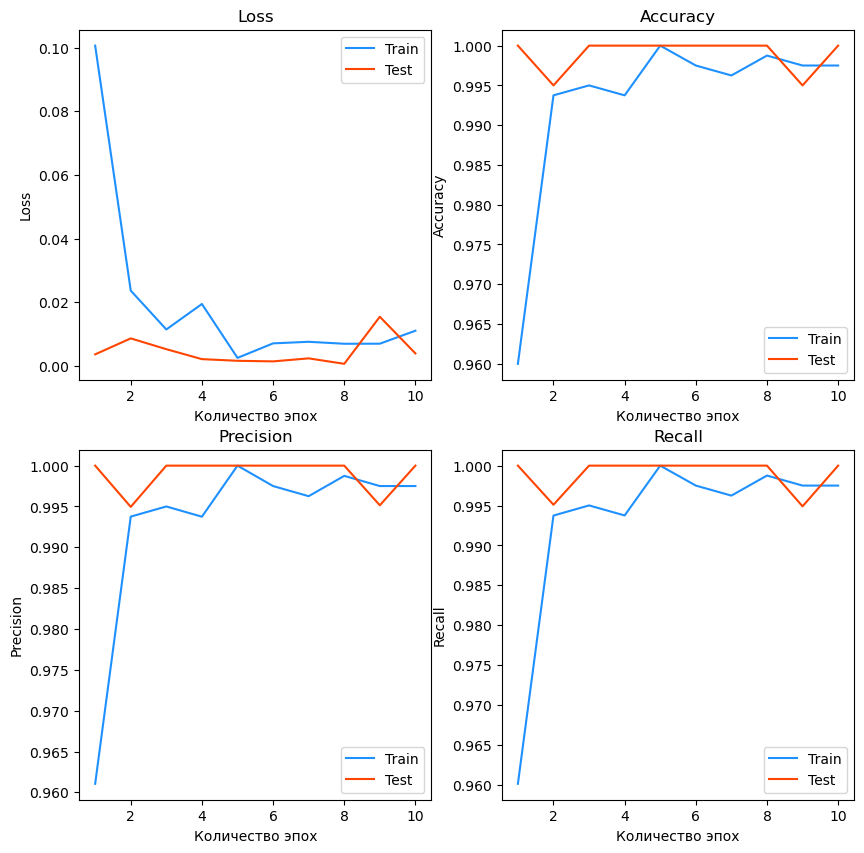

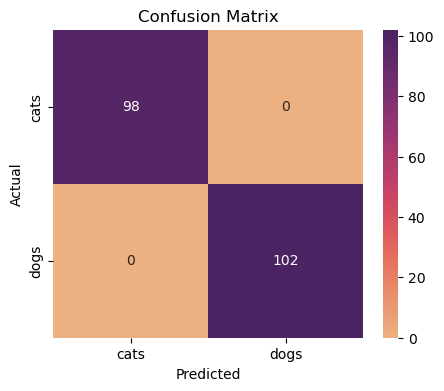

In [49]:
train_loader, test_loader = data_split(dataset)
model, criterion, optimizer = model_construction(dataset,lr=0.0001, weight_decay=0)
metrics, test_labels, test_predicted = train_and_evaluation(model, criterion, optimizer, train_loader, test_loader,
                                                           num_epochs = 10)
    
plot_metrics(metrics, 'Before_regularization')
plot_confusion_matrix(test_labels, test_predicted, 'Before_regularization')

### Модель с L2-регуляризацией

Epoch 1/10


Epoch [1/10]

Train metrics
Loss: 0.6565, Accuracy: 0.6100, Precision: 0.6100, Recall: 0.6100

Test metrics
Loss: 1.0938, Accuracy: 0.5050, Precision: 0.7487, Recall: 0.5147

Epoch 2/10


Epoch [2/10]

Train metrics
Loss: 0.5302, Accuracy: 0.7462, Precision: 0.7469, Recall: 0.7461

Test metrics
Loss: 0.7068, Accuracy: 0.7050, Precision: 0.7762, Recall: 0.7100

Epoch 3/10


/home/pgurzhii/miniforge3/envs/hic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [3/10]

Train metrics
Loss: 0.3941, Accuracy: 0.8125, Precision: 0.8154, Recall: 0.8123

Test metrics
Loss: 3.5143, Accuracy: 0.5100, Precision: 0.2550, Recall: 0.5000

Epoch 4/10


Epoch [4/10]

Train metrics
Loss: 0.3601, Accuracy: 0.8375, Precision: 0.8381, Recall: 0.8374

Test metrics
Loss: 2.8612, Accuracy: 0.5200, Precision: 0.7576, Recall: 0.5102

Epoch 5/10


Epoch [5/10]

Train metrics
Loss: 0.3174, Accuracy: 0.8750, Precision: 0.8782, Recall: 0.8748

Test metrics
Loss: 0.2780, Accuracy: 0.8900, Precision: 0.8900, Recall: 0.8900

Epoch 6/10


Epoch [6/10]

Train metrics
Loss: 0.2155, Accuracy: 0.9038, Precision: 0.9049, Recall: 0.9036

Test metrics
Loss: 0.4366, Accuracy: 0.8500, Precision: 0.8864, Recall: 0.8469

Epoch 7/10


Epoch [7/10]

Train metrics
Loss: 0.1938, Accuracy: 0.9125, Precision: 0.9138, Recall: 0.9124

Test metrics
Loss: 0.1338, Accuracy: 0.9550, Precision: 0.9549, Recall: 0.9551

Epoch 8/10


Epoch [8/10]

Train metrics
Loss: 0.1420, Accuracy: 0.9525, Precision: 0.9525, Recall: 0.9525

Test metrics
Loss: 0.3627, Accuracy: 0.8750, Precision: 0.8935, Recall: 0.8728

Epoch 9/10


Epoch [9/10]

Train metrics
Loss: 0.1749, Accuracy: 0.9363, Precision: 0.9363, Recall: 0.9362

Test metrics
Loss: 0.2366, Accuracy: 0.9100, Precision: 0.9121, Recall: 0.9108

Epoch 10/10


Epoch [10/10]

Train metrics
Loss: 0.1547, Accuracy: 0.9450, Precision: 0.9460, Recall: 0.9449

Test metrics
Loss: 0.2124, Accuracy: 0.9200, Precision: 0.9322, Recall: 0.9184



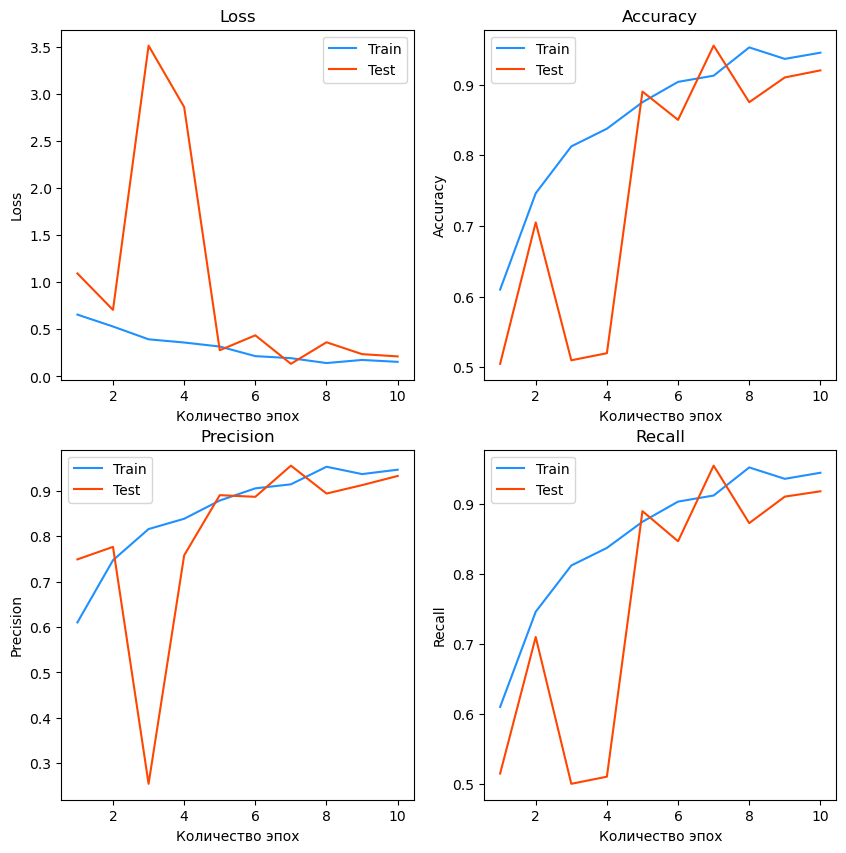

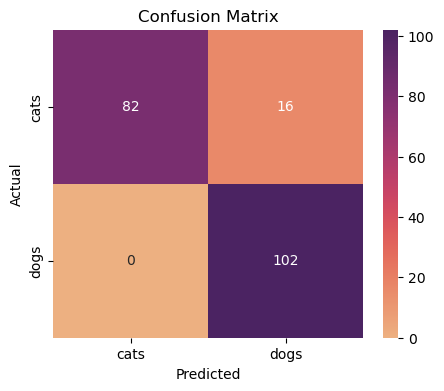

In [45]:
model_reg, criterion, optimizer_reg = model_construction(dataset,lr=0.0001, weight_decay=0.0001)

metrics_reg, test_labels_reg, test_predicted_reg = train_and_evaluation(model_reg, criterion, 
                                                                        optimizer_reg, train_loader, 
                                                                        test_loader,
                                                                       num_epochs = 10)
plot_metrics(metrics_reg, 'After_regularization')
plot_confusion_matrix(test_labels_reg, test_predicted_reg, 'After_regularization')

### Распределение весов модели до регуляризации и после L2-регуляризации

In [28]:
def get_weights(model):
    """Собрать все веса модели (исключая bias) в один массив."""
    weights = []
    for name, param in model.named_parameters():
        if 'weight' in name:  # Исключаем bias
            weights.extend(param.detach().cpu().flatten().numpy())
            # param.detach() - Отключает тензор от вычислительного графа PyTorch (градиенты не вычисляются)
            # cpu() - Перемещает тензор из GPU (если он там был) в CPU (для корректной работы numpy)
            # flatten() - Преобразует многомерный тензор в одномерный вектоhр
            # numpy() - Конвертирует тензор PyTorch в массив NumPy.
    return np.array(weights)

In [32]:
def plot_weights_distribution(initial_weights, reg_weights):

    plt.figure(figsize=(12, 6))

    # Гистограмма весов без регуляризации
    plt.hist(initial_weights, bins=100, alpha=0.5, label='Без регуляризации', color='blue')

    # Гистограмма весов после обучения с L2-регуляризацией
    plt.hist(reg_weights, bins=100, alpha=0.5, label='С L2-регуляризацией', color='red')

    # Настройки графика
    plt.xlabel('Значение весов')
    plt.ylabel('Частота')
    plt.title('Распределение весов до и после L2-регуляризации (weight_decay=0.01)')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')  # Логарифмическая шкала для оси Y (опционально)
    plt.savefig('weights_distribution')
    plt.show()

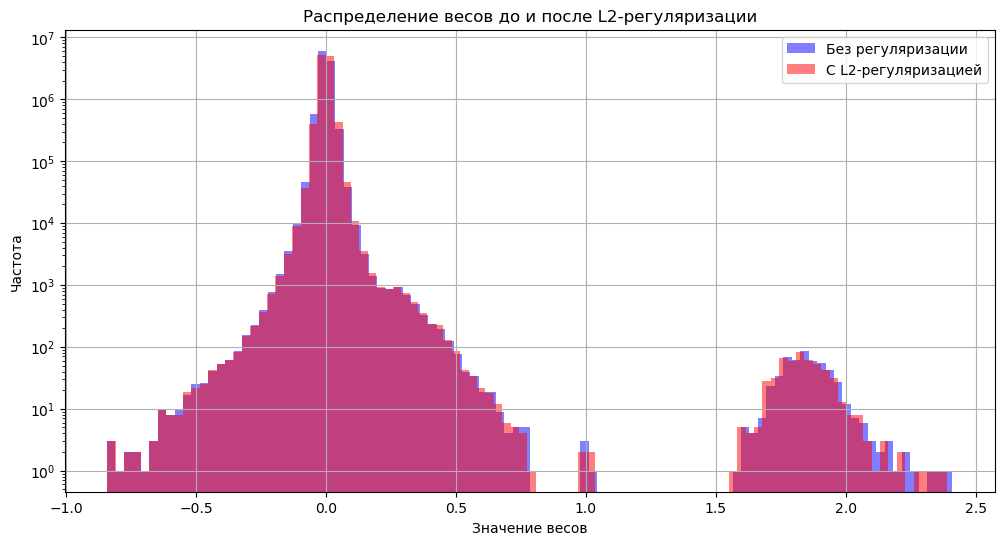

In [30]:
initial_weights = get_weights(model)
reg_weights = get_weights(model_reg)
plot_weights_distribution(initial_weights, reg_weights)

### Пример различия в распределении весов при более жесткой L2-регуляризации weight_decay = 0.01

/home/pgurzhii/miniforge3/envs/hic/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pgurzhii/miniforge3/envs/hic/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10


Epoch [1/10]

Train metrics
Loss: 0.1034, Accuracy: 0.9650, Precision: 0.9661, Recall: 0.9651

Test metrics
Loss: 0.0038, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 2/10


Epoch [2/10]

Train metrics
Loss: 0.0258, Accuracy: 0.9925, Precision: 0.9925, Recall: 0.9925

Test metrics
Loss: 0.0035, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 3/10


Epoch [3/10]

Train metrics
Loss: 0.0124, Accuracy: 0.9950, Precision: 0.9950, Recall: 0.9950

Test metrics
Loss: 0.0030, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 4/10


Epoch [4/10]

Train metrics
Loss: 0.0080, Accuracy: 0.9988, Precision: 0.9988, Recall: 0.9987

Test metrics
Loss: 0.0108, Accuracy: 0.9950, Precision: 0.9951, Recall: 0.9949

Epoch 5/10


Epoch [5/10]

Train metrics
Loss: 0.0041, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000

Test metrics
Loss: 0.0017, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 6/10


Epoch [6/10]

Train metrics
Loss: 0.0316, Accuracy: 0.9900, Precision: 0.9900, Recall: 0.9900

Test metrics
Loss: 0.0103, Accuracy: 0.9950, Precision: 0.9949, Recall: 0.9951

Epoch 7/10


Epoch [7/10]

Train metrics
Loss: 0.0151, Accuracy: 0.9950, Precision: 0.9950, Recall: 0.9950

Test metrics
Loss: 0.0103, Accuracy: 0.9950, Precision: 0.9951, Recall: 0.9949

Epoch 8/10


Epoch [8/10]

Train metrics
Loss: 0.0033, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000

Test metrics
Loss: 0.0022, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000

Epoch 9/10


Epoch [9/10]

Train metrics
Loss: 0.0044, Accuracy: 0.9988, Precision: 0.9988, Recall: 0.9987

Test metrics
Loss: 0.0080, Accuracy: 0.9950, Precision: 0.9951, Recall: 0.9949

Epoch 10/10


Epoch [10/10]

Train metrics
Loss: 0.0012, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000

Test metrics
Loss: 0.0049, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000



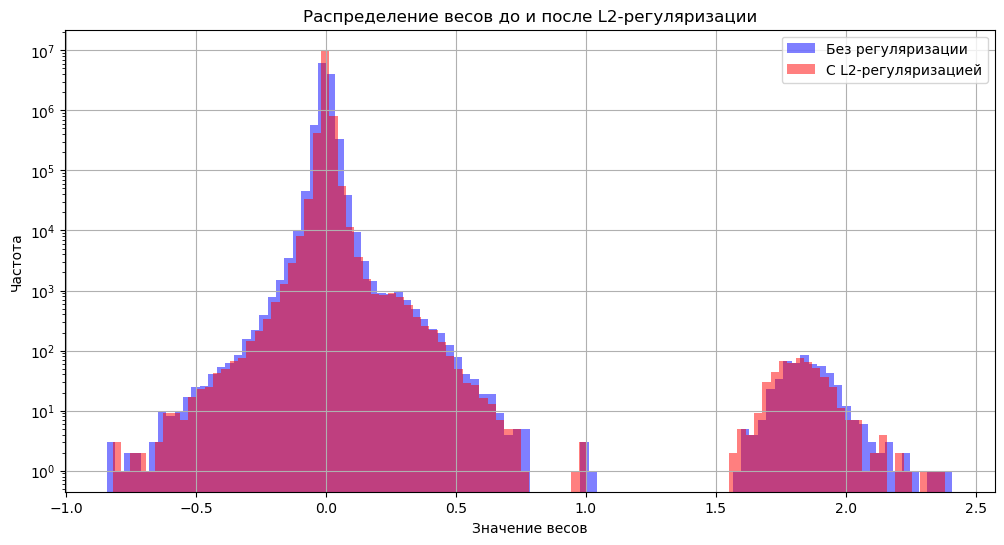

In [31]:
model_reg_2, criterion, optimizer_reg_2 = model_construction(dataset,lr=0.0001, 
                                                             weight_decay=0.01)

metrics_reg_2, test_labels_reg_2, test_predicted_reg_2 = train_and_evaluation(model_reg_2, criterion, 
                                                                        optimizer_reg_2, train_loader, 
                                                                        test_loader)
reg_weights_2 = get_weights(model_reg_2)
plot_weights_distribution(initial_weights, reg_weights_2)

Сильная регуляризация может заставить модель слишком сильно уменьшать веса, что приведет к недообучению. В результате модель может не улавливать важные закономерности в данных, что негативно скажется на её способности делать прогнозы